# Data acquisition and Basic Descriptions

In this section we accquire the aviation accident dataset and extract basic definitions and descriptions from it.

In [1]:
#Importing the essential libraries

import pandas as pd
import requests
import urllib
import numpy as np
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier

from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek

In [2]:
#Import the dataset from the github repository
url = 'https://github.com/aneezJaheez/Predicting-Aviation-Accidents-and-Injuries/blob/main/Data/Raw_Aviation_Data.csv'

#BaseData will hold the raw dataset as a pandas dataframe
baseData = pd.read_csv(url,encoding = "ISO-8859-1")

In [3]:
#Shape of the dataset as (rows, cols)
baseData.shape

(84262, 31)

In [4]:
#Dataset attribute datatypes and null-count
baseData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84262 entries, 0 to 84261
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                84262 non-null  object 
 1   Investigation.Type      84257 non-null  object 
 2   Accident.Number         84262 non-null  object 
 3   Event.Date              84262 non-null  object 
 4   Location                84185 non-null  object 
 5   Country                 83755 non-null  object 
 6   Latitude                30163 non-null  float64
 7   Longitude               30154 non-null  float64
 8   Airport.Code            47723 non-null  object 
 9   Airport.Name            50439 non-null  object 
 10  Injury.Severity         84262 non-null  object 
 11  Aircraft.Damage         81553 non-null  object 
 12  Aircraft.Category       27508 non-null  object 
 13  Registration.Number     80412 non-null  object 
 14  Make                    84192 non-null

In [5]:
#Description of numeric attributes
baseData.describe()

,Latitude,Longitude,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,30163.000000,30154.000000,79228.000000,57059.000000,54384.000000,55592.000000,69673.000000
mean,37.544907,-93.508337,1.146930,0.847614,0.331715,0.518708,5.901325
std,12.370282,39.454412,0.447004,6.292468,1.375602,2.771339,29.534302
min,-78.016945,-178.676111,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.307778,-114.861042,1.000000,0.000000,0.000000,0.000000,0.000000
50%,38.125278,-94.371667,1.000000,0.000000,0.000000,0.000000,1.000000
75%,42.524723,-81.650278,1.000000,1.000000,0.000000,1.000000,2.000000
max,89.218056,179.618611,8.000000,349.000000,111.000000,380.000000,699.000000


In [6]:
#Basic Descriptions of non-numeric attributes
for i in baseData:
    if baseData[i].dtypes != 'float64':
        print(baseData[i].describe(), '\n\n')

count              84262
unique             83035
top       20100204X45658
freq                   3
Name: Event.Id, dtype: object 


count        84257
unique           2
top       Accident
freq         80814
Name: Investigation.Type, dtype: object 


count          84262
unique         84262
top       CEN10LA370
freq               1
Name: Accident.Number, dtype: object 


count          84262
unique         13718
top       1984-06-30
freq              25
Name: Event.Date, dtype: object 


count             84185
unique            26575
top       ANCHORAGE, AK
freq                372
Name: Location, dtype: object 


count             83755
unique              179
top       United States
freq              78849
Name: Country, dtype: object 


count     47723
unique    10019
top        NONE
freq       1473
Name: Airport.Code, dtype: object 


count       50439
unique      23863
top       PRIVATE
freq          217
Name: Airport.Name, dtype: object 


count         84262
unique          12

# Extraction and Data Cleanup

This section will deal with converting the raw data into information by extracting relevant and formatting the dataset according to the scope of the project.

In [7]:
#Dropping the attributes that will not be relevant to the project
aviationData = pd.DataFrame(baseData[['Latitude', 'Longitude', 'Injury.Severity', 'Aircraft.Damage', 'Aircraft.Category', 'Number.of.Engines', 'Engine.Type', 'Purpose.of.Flight', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', 'Weather.Condition', 'Broad.Phase.of.Flight', 'Amateur.Built', 'FAR.Description']])

In [8]:
#Standardizing all the non-numeric attributes by making it uppercase
for i in aviationData:
    if(aviationData[i].dtypes != 'float64' and aviationData[i].dtypes != 'int64'):
        aviationData[i] = aviationData[i].str.upper()

In [9]:
#Removing all the amatuer built aircrafts since these will not be considered in this project
aviationData = aviationData[aviationData['Amateur.Built'] == 'NO']
aviationData = aviationData.drop(['Amateur.Built'], axis = 1)

In [10]:
#Filling up NaN values with 0 for airplanes that have no passengers
for i in aviationData:
    if(i == 'Number.of.Engines'):
        continue
        
    if(aviationData[i].dtypes == 'float64' and i != 'Latitude' and i != 'Longitude'):
        aviationData[i] = aviationData[i].fillna(0)

In [11]:
#Calculating the total passenger count in the airplane as a sum of total injured passengers and total uninjured passengers.
aviationData['Total.Passengers'] = 0

for index, row in aviationData.iterrows():
    totalPassengers = aviationData.at[index, 'Total.Fatal.Injuries'] + aviationData.at[index, 'Total.Serious.Injuries'] + aviationData.at[index, 'Total.Minor.Injuries'] + aviationData.at[index, 'Total.Uninjured']
    
    #Based on our research, we conculded that commercial airplanes are airplanes with at least 30 passengers or more.
    #Hence, in records with missing aircraft categories, we assume that such air vehicles are commercial airplanes.
    if(totalPassengers > 30):
        aviationData.at[index, 'Aircraft.Category'] = 'AIRPLANE'
    aviationData.at[index, 'Total.Passengers'] = totalPassengers

In [12]:
#Removing non-commercial aircraft data from the dataset.
aviationData = aviationData[aviationData['Aircraft.Category'] == 'AIRPLANE']

aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'FIREFIGHTING']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'GLIDER TOW']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'AIR DROP']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'SKYDIVING']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'INSTRUCTIONAL']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'BANNER TOW']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'AERIAL OBSERVATION']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'AIR RACE/SHOW']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'AERIAL APPLICATION']

In [13]:
#This snippet maps several inconsistent records for the "purpose.of.flight" attribute to one consistent value

for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Purpose.of.Flight'] == 'PUBLIC AIRCRAFT - STATE' or aviationData.at[index, 'Purpose.of.Flight'] == 'PUBLIC AIRCRAFT - FEDERAL' or aviationData.at[index, 'Purpose.of.Flight'] == 'PUBLIC AIRCRAFT - LOCAL'):
        aviationData.at[index, 'Purpose.of.Flight'] = 'PUBLIC AIRCRAFT'

In [14]:
#Dropping rows with incomplete flight state info since this information is critical in making predictions about 
#how the accident was caused.

for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Broad.Phase.of.Flight'] == 'UNKNOWN'):
        aviationData = aviationData.drop(index)
    
aviationData = aviationData.dropna(axis=0, subset=['Broad.Phase.of.Flight'])

In [15]:
#Removing rows with incomplete location data
for index, row in aviationData.iterrows():
    if(pd.isnull(aviationData.at[index, 'Latitude'])):
        aviationData.at[index, 'Latitude'] = aviationData['Latitude'].mean()
        
    if(pd.isnull(aviationData.at[index, 'Longitude'])):
        aviationData.at[index, 'Longitude'] = aviationData['Longitude'].mean()

In [16]:
#Dropping rows with incomplete passenger data
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Total.Passengers'] == 0):
        aviationData = aviationData.drop(index)

aviationData = aviationData.drop(['Aircraft.Category'], axis = 1)

In [17]:
#Specifying "unknown" in records containing NaN engine information
for index, row in aviationData.iterrows():
    if(pd.isnull(aviationData.at[index,'Engine.Type'])):
            aviationData.at[index, 'Engine.Type'] = 'UNKNOWN'

In [18]:
#The aviation accidents provided in the dataset fall into categories; fatal, non-fatal, and incidents
for index, row in aviationData.iterrows():
    if(row['Injury.Severity'] != 'NON-FATAL' and row['Injury.Severity'] != 'INCIDENT'):
        aviationData.at[index, 'Injury.Severity'] = 'FATAL'
        
#Based on research, we further assume that common commercial aircrafts have an engine count of 4.
for index, row in aviationData.iterrows():
    if(row['Number.of.Engines'] == 0):
        aviationData.at[index, 'Number.of.Engines'] = 4

for index, row in aviationData.iterrows():
    if(pd.isnull(row['Number.of.Engines'])):
        aviationData.at[index, 'Number.of.Engines'] = 4

In [19]:
#Specifying "unknown" in records containing NaN flight purpose information
for index, row in aviationData.iterrows():
    if(pd.isnull(aviationData.at[index,'Purpose.of.Flight'])):
        aviationData.at[index, 'Purpose.of.Flight'] = 'UNKNOWN'

In [20]:
#Filling in missing damage data
for index, row in aviationData.iterrows():
    if(pd.isnull(aviationData.at[index,'Aircraft.Damage'])):
        if(aviationData.at[index,'Broad.Phase.of.Flight'] == 'LANDING' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'CRUISE' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'MANEUVERING' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'LANDING'):
            aviationData.at[index, 'Aircraft.Damage'] = 'DESTROYED'
        elif(aviationData.at[index,'Broad.Phase.of.Flight'] == 'GO-AROUND' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'STANDING' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'TAXI' or aviationData.at[index, 'Aircraft.Damage'] == 'CLIMB'):
            aviationData.at[index, 'Aircraft.Damage'] = 'MINOR'
        else:
            aviationData.at[index, 'Aircraft.Damage'] = 'SUBSTANTIAL'

In [21]:
aviationData = aviationData[aviationData['FAR.Description'].notna()]

In [22]:
#Removing flights that are irrelevant to the problem
aviationData = aviationData[aviationData['FAR.Description'] != 'ARMED FORCES']
aviationData = aviationData[aviationData['FAR.Description'] != 'PAR 91 SUBPART K: FRACTIONAL']
aviationData = aviationData[aviationData['FAR.Description'] != 'PART 137: AGRICULTURAL']
aviationData = aviationData[aviationData['FAR.Description'] != 'PART 125: 20+ PAX 6000+ LBS']

In [23]:
#Removing records engine types that do not match commercial aircrafts
aviationData = aviationData[aviationData['Engine.Type'] != 'TURBO SHAFT']
aviationData = aviationData[aviationData['Engine.Type'] != 'ELECTRIC']
aviationData = aviationData[aviationData['Engine.Type'] != 'REC, TJ, TJ']

In [24]:
aviationData = aviationData[aviationData['Broad.Phase.of.Flight'] != 'OTHER']
aviationData = aviationData.drop(['FAR.Description'], axis = 1)

In [25]:
#Ensuring injury severity matches fatality data
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Injury.Severity'] == 'FATAL'):
        if(aviationData.at[index, 'Total.Fatal.Injuries'] == 0):
            aviationData.drop(index)
    else:
        if(aviationData.at[index, 'Total.Fatal.Injuries'] > 0):
            aviationData.drop(index)

In [26]:
#Converting whole number data to integer
for i in aviationData:
    if(aviationData[i].dtypes == 'float64' and i != 'Latitude' and i != 'Longitude'):
        aviationData[i] = aviationData[i].astype('int64')

In [27]:
#Reinitializing the indices for the rows to make them ordered and sequential
aviationData.index = range(len(aviationData))

Based on the location of the airplane at the time of the accident, we determine the land elevation at that point. This code snippet has not been run because it has special access permissions. Instead, we have run it once and stored the retrived data under the file ElevationData.txt

In [28]:
#Using the given data in the dataset to determine the approximate altitude of the airplane during the accident

# USGS Elevation Point Query Service
url = r'https://nationalmap.gov/epqs/pqs.php?'

# create data frame
df = pd.DataFrame({
    'lat': aviationData['Latitude'][:1],
    'lon': aviationData['Longitude'][:1]
})

def elevation_function(df, lat_column, lon_column):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):

        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])

    df['elev_meters'] = elevations

elevation_function(df, 'lat', 'lon')
df.head()

,lat,lon,elev_meters
0,39.128611,-123.715833,40.24


# Estimating the altitude of the Airplane

During the exploratory analysis, we found that the approximate altitude and location of the aircraft played a major role in the accuracy of the predictions. Hence, based on altitudes of commercial aircrafts at different phases of flying and the elevation of land at the aircraft location, we estimated the altitude of the aircraft at the time of the accident.

The previous code to estimate retrieve elevation takes too long to execute for a large number of records. Hence we have retrieved it once and pasted it in the existing csv file to avoid any overheads, and then imported the file again in this program. Besides the addition of elevation, the contents are exactly the same.

In [29]:
url = 'https://raw.githubusercontent.com/aneezJaheez/Predicting-Aviation-Accidents-and-Injuries/main/Data/aviation_data_with_elevations.csv'
aviationData = pd.read_csv(url,encoding = "ISO-8859-1")
aviationData = aviationData.rename(columns={'ï»¿Altitude': 'Altitude'})

In [30]:
#Using the data in our dataset and added elevation data to predict aircraft altitude
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Broad.Phase.of.Flight'] == 'CRUISE' or aviationData.at[index, 'Broad.Phase.of.Flight'] == 'MANEUVERING' or aviationData.at[index, 'Broad.Phase.of.Flight'] == 'GO-AROUND'):
        if(aviationData.at[index, 'Purpose.of.Flight'] == 'PERSONAL'):
            altitude = 12496.8 - aviationData.at[index, 'Altitude']
            if(altitude > 0):
                aviationData.at[index, 'Altitude'] = altitude
        else:
            altitude = 10972 - aviationData.at[index, 'Altitude']
            if(altitude > 0):
                aviationData.at[index, 'Altitude'] = altitude
    
    if(aviationData.at[index, 'Broad.Phase.of.Flight'] == 'APPROACH' or aviationData.at[index, 'Broad.Phase.of.Flight'] == 'DESCENT' or aviationData.at[index, 'Broad.Phase.of.Flight'] == 'CLIMB'):
        altitude = 700 - aviationData.at[index, 'Altitude']
        if(altitude > 0):
            aviationData.at[index, 'Altitude'] = altitude

In [31]:
aviationData

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
0,367.2,39.164723,-96.610412,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,0,0,0,588,VMC,STANDING,588
1,367.2,39.164723,-96.610412,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,0,0,0,588,VMC,TAXI,588
2,202.7,41.968611,-87.907778,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,STANDING,501
3,202.7,41.968611,-87.907778,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,TAXI,501
4,215.4,35.213611,-80.948889,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,454,VMC,STANDING,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13005,10604.8,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,FERRY,0,0,0,1,VMC,CRUISE,1
13006,332.8,39.164723,-96.610412,INCIDENT,MINOR,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,APPROACH,1
13007,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,FERRY,0,0,0,1,VMC,TAKEOFF,1
13008,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,TAXI,1


In [32]:
#Replacing unkown weather condition data with NaN
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Weather.Condition'] == 'UNK'):
        aviationData.at[index, 'Weather.Condition'] = np.nan
        
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Altitude'] < 0):
        aviationData.at[index, 'Altitude'] = 0

# Predicting Missing Weather data using AdaBoost

During our exploratory analysis of the dataset, we noticed that the weather has a strong correlation with the accidents and play a major role in predicting them. Hence, we use our existing attributes to predict the weather in records where this data is missing.

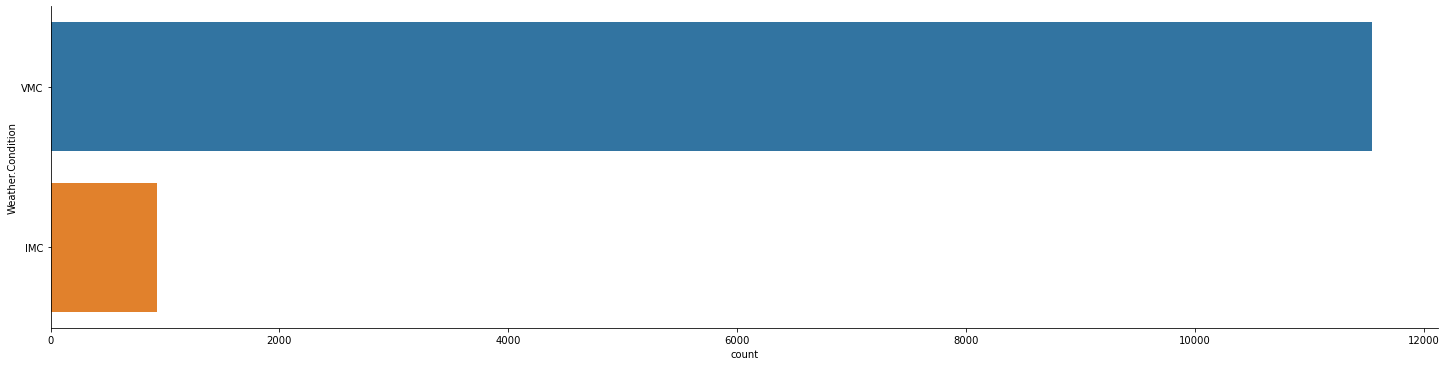

In [33]:
#Visualizing the number of records for each type of aviation weather condition.
sb.catplot(y = 'Weather.Condition', data = aviationData, kind = "count", height = 5, aspect = 4)

Notice that the weather data is heavily imbalanced, with over 90% of the data records containing a value of 'VMC' in the weather condition. This data needs to be balanced in order to make accurate weather predictions.

In [34]:
#We make predictions on the values for weather that are missing
finaltest = pd.DataFrame(aviationData[aviationData['Weather.Condition'].isnull()])

#We train the model on records with available weather condition values
training = pd.DataFrame(aviationData[aviationData['Weather.Condition'].notnull()])

In [35]:
y = pd.DataFrame(training["Weather.Condition"])
X = pd.DataFrame(training[["Total.Fatal.Injuries", "Total.Serious.Injuries","Total.Minor.Injuries","Total.Uninjured","Total.Passengers"]])
# remap weather condition, IMC = true, VMC = false
for index, row in y.iterrows():
    if(y.at[index,'Weather.Condition'] == 'IMC'):
        y.at[index, 'Weather.Condition'] = True;
    else:
        y.at[index, 'Weather.Condition'] = False;
        
y['Weather.Condition'] = y['Weather.Condition'].astype('bool')

In [36]:
y.columns = ['WeatherCondition']

In [37]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (11232, 1) (11232, 5)
Test Set  : (1249, 1) (1249, 5)


In [38]:
#Balancing the datasets using imblearn to make more accurate and meaningful predictions about the weather
columns = X_train.columns.tolist()
target = 'Weather.Condition'
state = np.random.RandomState(42)
print(X_train.shape)
print(y_train.shape)

(11232, 5)
(11232, 1)


In [39]:
pd.DataFrame(y_train.WeatherCondition.value_counts())

,WeatherCondition
False,10417
True,815


In [40]:
#Data balancing by oversampling minority class
nm = NearMiss()
smk = SMOTETomek(random_state = 42)
X_train, y_train = smk.fit_resample(X_train, y_train)
pd.DataFrame(y_train.WeatherCondition.value_counts())

,WeatherCondition
True,10411
False,10411


In [41]:
# Basse Decision tree
dectree = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)  
dectree.fit(X_train, y_train) 

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7358082797041591



In [42]:
#Boosting the base tree with AdaBoost
AdaBoost = AdaBoostClassifier(base_estimator = dectree, n_estimators = 100, learning_rate = 0.1)
boostModel = AdaBoost.fit(X_train,y_train)
pred = boostModel.predict(X_test)

predictions = metrics.accuracy_score(y_test,pred)

print("prediction accuracy is: ",predictions*100,"%")

/Users/aneez.jaheez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


prediction accuracy is:  79.42353883106486 %


In [43]:
#Predicting the unknown weather values
unk = pd.DataFrame(finaltest[["Total.Fatal.Injuries", "Total.Serious.Injuries","Total.Minor.Injuries","Total.Uninjured","Total.Passengers"]])

actualPred = boostModel.predict(unk)
actualPred = pd.DataFrame(actualPred, columns = ["Weather.Condition"], index = finaltest.index)
finaltest["Weather.Condition"] = actualPred["Weather.Condition"].values

finaltest['Weather.Condition'] = finaltest['Weather.Condition'].astype('object')

#Reverting true, false to the actual weather values
for index, row in finaltest.iterrows():
    if(finaltest.at[index,'Weather.Condition'] == 'True'):
        finaltest.at[index, 'Weather.Condition'] = 'IMC';
    else:
        finaltest.at[index, 'Weather.Condition'] = "VMC";

In [44]:
frames = [training,finaltest]
aviationData = pd.concat(frames)

In [45]:
aviationData = aviationData.dropna()
aviationData.index = range(len(aviationData.index))

In [46]:
aviationData

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
0,367.2,39.164723,-96.610412,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,0,0,0,588,VMC,STANDING,588
1,367.2,39.164723,-96.610412,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,0,0,0,588,VMC,TAXI,588
2,202.7,41.968611,-87.907778,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,STANDING,501
3,202.7,41.968611,-87.907778,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,TAXI,501
4,215.4,35.213611,-80.948889,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,454,VMC,STANDING,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12949,367.2,39.164723,-96.610412,NON-FATAL,DESTROYED,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,LANDING,1
12950,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,BUSINESS,0,0,0,1,VMC,TAXI,1
12951,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,UNKNOWN,0,0,0,1,VMC,LANDING,1
12952,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,2,RECIPROCATING,UNKNOWN,0,0,1,0,VMC,TAKEOFF,1


This completes the data cleaning process. With the cleaned datasets, we can start analysing the information to make meaningful predictions

In [47]:
aviationData.to_csv("cleaned_aviation_dataset_final.csv")